# Gradients

In [1]:

import invertwin as ivt
import drjit
from drjit.cuda.ad import Float as FloatD, Matrix4f as Matrix4fD
from drjit.cuda import Matrix4f as Matrix4fC

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.autograd.forward_ad as fwAD

In [2]:
# seed all
torch.manual_seed(0)
np.random.seed(0)


In [3]:
scene = ivt.Scene()
scene.opts.spp = 128
scene.opts.sppe = 0
scene.opts.sppse = 0
scene.opts.height = 128 
scene.opts.width = 128

integrator = ivt.DemoIntegrator()


## Scene Setup

In [4]:
sensor = ivt.Radar(70, 0.000001, 10000000.)
sensor.to_world = Matrix4fD([[-1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,-1.,0.],[0.,0.,0.,1.],])
scene.add_Sensor(sensor)
scene.add_Material(ivt.DiffuseMaterial([0.9, 0.9, 0.9]), "basic")
scene.add_Mesh("data/mesh/A.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,-100.],[0.,0.,0.,1.]]), "basic", None)
with drjit.suspend_grad():
    scene.configure()
    scene.configure([0])

## Parameterization
We set parameter $p$ to control the mesh's translation of Z axis.

In [5]:
P = FloatD(0.) 
drjit.enable_grad(P) 

scene.param_map["Mesh[0]"].set_transform(Matrix4fD([[1.,0.,0.,P*100],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.],]))
scene.configure([0])

tau = integrator.cir_diff(scene, 0)
tau2D = np.array(tau)[:,0].reshape(scene.opts.width, scene.opts.height)
tau_tensor = torch.tensor(tau2D)
tau_tensor[tau_tensor == 0] = 1e-6

Create the spatial spectrum surrogate model

In [6]:
spectrum_gen = ivt.SpartialSpectrumSurrogate()

## Differetation
Forward mode automatic differetation to obtain the gradient of the spectrum.

In [7]:
drjit.set_grad(P, 1.0)
drjit.forward_to(tau)
diff_tau = drjit.grad(tau)
diff_tau = diff_tau.numpy().reshape((scene.opts.width, scene.opts.height, 3)).mean(axis=2)

x = tau_tensor
x_grad = torch.tensor(diff_tau)

# Forward Mode AD
with fwAD.dual_level():
    dual_x = fwAD.make_dual(x, x_grad)
    dual_y = spectrum_gen(dual_x)
    y = fwAD.unpack_dual(dual_y).primal
    y_grad = fwAD.unpack_dual(dual_y).tangent

## Visualization
A side view of the 3D spectrum.

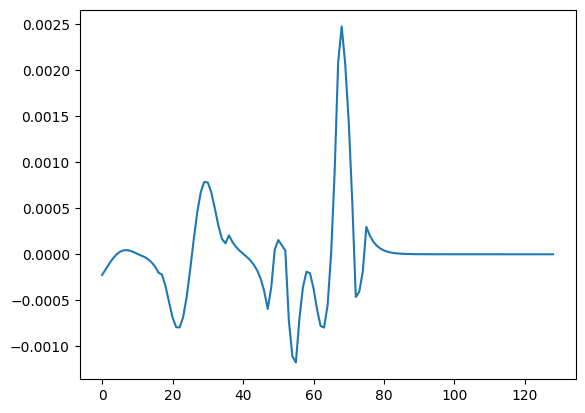

In [8]:
plt.plot(y_grad[65,65])

Normalization for visualization, we want to ensure that a gradient of 0 remains at 0 when plotting.

In [9]:
def normalize_image_symmetric(image):
    image = np.copy(image)
    max_val = np.max(image)
    min_val = np.min(image)
    positive_mask = image > 0
    negative_mask = image < 0
    
    normalized_image = np.zeros_like(image)

    if np.any(positive_mask):
        normalized_image[positive_mask] = image[positive_mask] / max_val

    if np.any(negative_mask):
        normalized_image[negative_mask] = -image[negative_mask] / min_val
    
    return normalized_image

## Results
Projection of the 3D Spectrum Gradient onto a 2D Surface

(-0.5, 128.5, 128.5, -0.5)

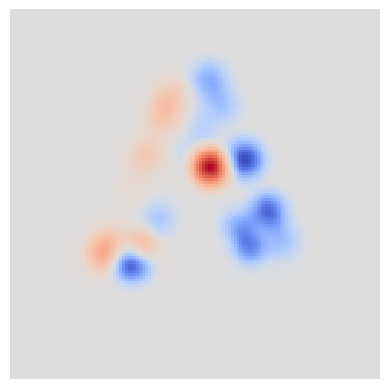

In [10]:

plt.imshow(normalize_image_symmetric(torch.sum(y_grad[:,:,20:80],dim=2).numpy()), interpolation='none', cmap=plt.cm.coolwarm)
plt.axis('off')